<a href="https://colab.research.google.com/github/Howl06/classify_project_final/blob/main/tensorflow.keras/Hw_vessel_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image
import os
from glob import glob
from tqdm.auto import tqdm

# data augmentation
import imgaug.augmenters as iaa
import imgaug as ia

import tensorflow as tf
from tensorflow.keras import *
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
import pandas as pd

#### Download data

In [4]:
# download dataset from https://drive.google.com/file/d/1JILW10sr40CRTLiuA1mf__5GBtMDF9xc/view?usp=sharing
!gdown --fuzzy 1JILW10sr40CRTLiuA1mf__5GBtMDF9xc --output vessel_seg.zip

Downloading...
From: https://drive.google.com/uc?id=1JILW10sr40CRTLiuA1mf__5GBtMDF9xc
To: /content/vessel_seg.zip
100% 29.2M/29.2M [00:00<00:00, 184MB/s]


In [5]:
# unzip file
!unzip -q vessel_seg.zip

#### Data Analysis

In [6]:
# read img and mask
img_paths = glob('all/train/*.tif')
img_path = np.random.choice(img_paths, size=1)[0]
mask_path = img_path.replace('_training.tif', '_manual1.gif')

print('img path: ', img_path)
print('mask path:',  mask_path)

img = cv2.imread(img_path)[:, :, ::-1] # BGR -> RGB
mask = Image.open(mask_path)
mask = np.array(mask)

img.shape, mask.shape

img path:  all/train/24_training.tif
mask path: all/train/24_manual1.gif


((584, 565, 3), (584, 565))

In [7]:
len(img_paths)

20

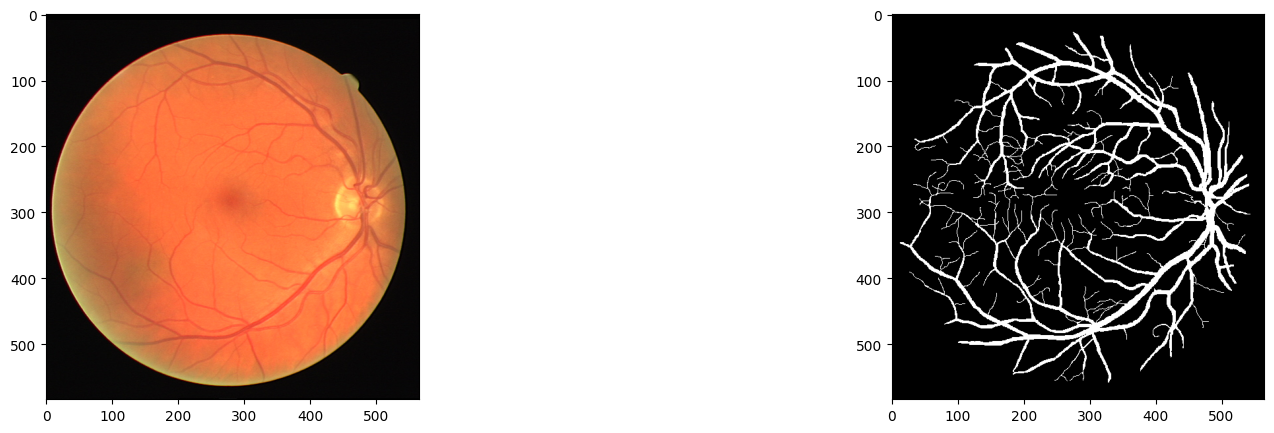

In [8]:
# show image
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
# plt.imshow(mask)
plt.show()

In [9]:
img.shape, mask.shape

((584, 565, 3), (584, 565))

In [10]:
np.unique(mask, return_counts=True)

(array([  0, 255], dtype=uint8), array([291731,  38229]))

#### Data processing

In [11]:
IMG_SIZE = 512 # 16X Kaggle: 512
BS = 4

In [13]:
class DataGenerator(utils.Sequence):
    def __init__(self, img_paths, batch_size, img_size, shuffle=True, 
                 mode='train', aug=False):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.img_size = img_size
        self.mode = mode
        self.img_paths = img_paths
        self.mask_paths = [p.replace('_training.tif', '_manual1.gif') for p in self.img_paths]
        # same data augmentation(target , mask)
        self.aug = aug
        self.indexes = np.arange(len(self.mask_paths))
        self.seq = iaa.Sequential([
            iaa.Fliplr(0.5), # 50% horizontal flip
            iaa.Flipud(0.5),
            iaa.Affine(
                rotate=(90, -90), # random rotate -45 ~ +45 degree
                shear=(-3, 3), # random shear -3 ~ +3 degree
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)} # scale x, y: 80%~120%
            ),
        ])
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.mask_paths) / self.batch_size)) # batches per epoch

    def __getitem__(self, batch_index):
        # Generate indexes of the batch
        idxs = self.indexes[batch_index * self.batch_size:(batch_index + 1) * self.batch_size]
        # Find list of IDs
        batch_img_paths = [self.img_paths[i] for i in idxs]
        batch_mask_paths = [self.mask_paths[i] for i in idxs]

        # Generate data
        X, y = self.__data_generation(batch_img_paths, batch_mask_paths)
        if self.mode != 'test':
            return X, y
        else:
            return X

    def on_epoch_end(self):
        # Updates indexes after each epoch
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, img_paths, mask_paths):
        # Generates data containing batch_size samples
        x = np.empty((len(img_paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.empty((len(img_paths), self.img_size, self.img_size, 1), dtype=np.float32)

        for i, (img_path, mask_path) in enumerate(zip(img_paths, mask_paths)):
            img = cv2.imread(img_path)[:, :, ::-1]
            img = self.preprocess(img) # 0~255 -> 0~1
            x[i] = img
            if self.mode != 'test':
                mask = np.array(Image.open(mask_path))
                mask = self.preprocess(mask) # 0 or 255 -> 0 or 1
                # torch squeeze
                y[i] = np.expand_dims(mask, axis=-1) # (512, 512) -> (512, 512, 1)
        # Augmentation
        if self.aug:
            x, y = self.seq(images=x, heatmaps=y) # imgaug
        return x, y

    def preprocess(self, img):
        data = cv2.resize(img, (self.img_size, self.img_size))
        data = data / 255. # normalize to 0~1
        return data

In [14]:
all_paths = glob('all/train/*.tif')
test_paths = sorted(glob('all/test/*.tif'))
train_paths, val_paths = train_test_split(all_paths, test_size=0.2)

train_gen = DataGenerator(train_paths, BS, IMG_SIZE, 
                          shuffle=True, mode='train', 
                          aug=True)
val_gen = DataGenerator(val_paths, BS, IMG_SIZE, shuffle=False, mode='val')


In [15]:
test_gen = DataGenerator(test_paths, BS, IMG_SIZE, shuffle=False, mode='test')

In [16]:
len(train_paths), len(val_paths)

(16, 4)

(4, 512, 512, 3) (4, 512, 512, 1)


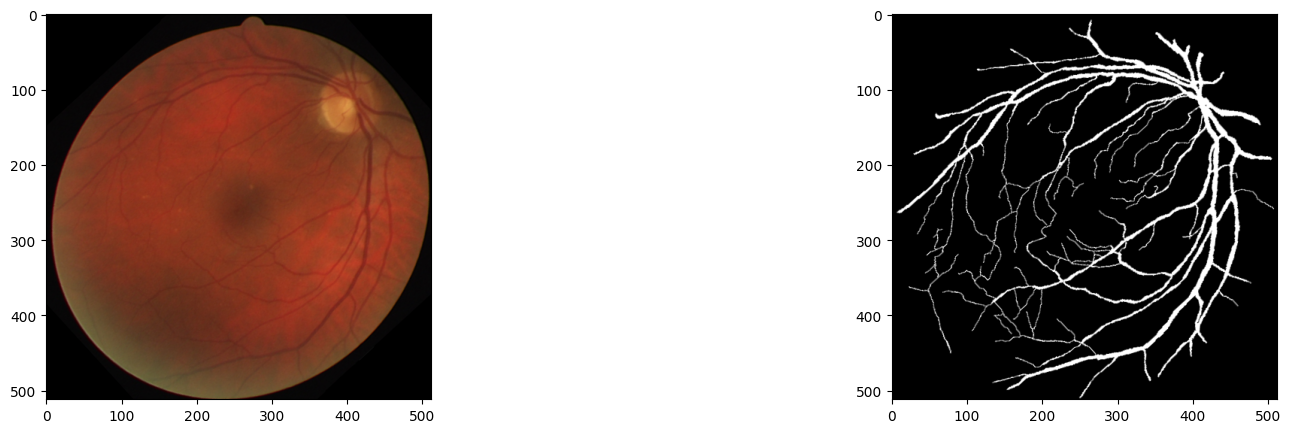

In [17]:
# Check output

batch_x, batch_y = train_gen[0]
print(batch_x.shape, batch_y.shape)

# batch_i = np.random.choice(len(batch_x))
batch_i = 0

plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.imshow(batch_x[batch_i])
plt.subplot(1,2,2)
plt.imshow(batch_y[batch_i, :, :, 0], cmap='gray')
plt.show()

#### Build model: U-Net

In [18]:
BASE_FILTERS = 8

In [31]:
def conv_bn(x, filters):
    x = layers.Conv2D(filters=filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def inception(x, nb_filter):
    branch1x1 = layers.Conv2D(nb_filter, (1,1), padding='same', activation='relu')(x)

    branch3x3 = layers.Conv2D(nb_filter//4, (1,1), padding='same', activation='relu')(x)
    branch3x3 = layers.Conv2D(nb_filter, (3,3), padding='same', activation='relu')(branch3x3)
    
    branch5x5 = layers.Conv2D(nb_filter//4, (1,1), padding='same', activation='relu')(x)
    branch5x5 = layers.Conv2D(nb_filter, (5,5), padding='same', activation='relu')(branch5x5)
    
    branchpool = layers.MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(x)
    branchpool = layers.Conv2D(nb_filter//2, (1,1), padding='same', activation='relu')(branchpool)
    
    x = layers.concatenate([branch1x1, branch3x3, branch5x5, branchpool], axis=-1)
    return x

def identity_block(input_tensor, filters, kernel_size=3):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
    """
    filters1, filters2, filters3 = filters # ex: [64, 64, 256]
    bn_axis = -1

    x = layers.Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization(axis=bn_axis)(x)

    x = layers.add([x, input_tensor]) # skip connection
    x = layers.Activation('relu')(x)
    return x
# strides 2
def conv_block(input_tensor,
               filters,
               kernel_size=3,
               strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        strides: Strides for the first conv layer in the block.
    """
    filters1, filters2, filters3 = filters
    bn_axis = -1

    x = layers.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',)(x)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization(axis=bn_axis)(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal')(input_tensor)
    shortcut = layers.BatchNormalization(axis=bn_axis)(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_model():

    # conv_bn = inception

    # Encoder
    input_layer = layers.Input(shape=(None, None, 3))
    # input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = conv_bn(input_layer, BASE_FILTERS)
    c1 = conv_bn(x, BASE_FILTERS)
    x = layers.MaxPool2D(strides=(2,2))(c1)
    x = conv_bn(x, BASE_FILTERS*2)
    c2 = conv_bn(x, BASE_FILTERS*2)
    x = layers.MaxPool2D(strides=(2,2))(c2)
    x = conv_bn(x, BASE_FILTERS*4)
    c3 = conv_bn(x, BASE_FILTERS*4)
    x = layers.MaxPool2D(strides=(2,2))(c3)
    x = conv_bn(x, BASE_FILTERS*8)
    c4 = conv_bn(x, BASE_FILTERS*8)

    # Decoder
    x = layers.concatenate([#layers.UpSampling2D(size=(2,2))(c4),
                            layers.Conv2DTranspose(32, 3, strides=2, padding='same')(c4),
                            c3], axis=-1)
    x = conv_bn(x, 32)
    x = conv_bn(x, 32)
    x = layers.concatenate([#layers.UpSampling2D(size=(2,2))(x), 
                            layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x),
                            c2], axis=-1)
    x = conv_bn(x, 64)
    x = conv_bn(x, 64)
    x = layers.concatenate([#layers.UpSampling2D(size=(2,2))(x), 
                            layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x),
                            c1], axis=-1)
    x = conv_bn(x, 128)
    x = conv_bn(x, 128)

    output_layer = layers.Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(x)
                                                            
    model = models.Model(input_layer, output_layer)
    return model



In [41]:
def build_resunet():

    # [BASE_FILTERS, BASE_FILTERS, BASE_FILTERS*4]
    filters1 = [BASE_FILTERS, BASE_FILTERS, BASE_FILTERS*4]
    filters2 = [BASE_FILTERS*2, BASE_FILTERS*2, BASE_FILTERS*8]
    filters3 = [BASE_FILTERS*4, BASE_FILTERS*4, BASE_FILTERS*16]
    filters4 = [BASE_FILTERS*8, BASE_FILTERS*8, BASE_FILTERS*32]

    input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = conv_bn(input_layer, BASE_FILTERS*4)

    x = identity_block(x, filters1)
    c1 = identity_block(x, filters1)
    # x = layers.MaxPool2D(strides=(2,2))(c1)
    x = conv_block(c1, filters2)
    x = identity_block(x, filters2)
    c2 = identity_block(x, filters2)
    # x = layers.MaxPool2D(strides=(2,2))(c2)
    x = conv_block(c2, filters3)
    x = identity_block(x, filters3)
    c3 = identity_block(x, filters3)
    # x = layers.MaxPool2D(strides=(2,2))(c3)
    x = conv_block(c3, filters4)
    x = identity_block(x, filters4)
    c4 = identity_block(x, filters4)

    x = layers.concatenate([#layers.UpSampling2D(size=(2,2))(c4),
                            layers.Conv2DTranspose(32, 3, strides=2, padding='same')(c4),
                            c3], axis=-1)
    x = conv_bn(x, 32)
    x = conv_bn(x, 32)
    x = layers.concatenate([#layers.UpSampling2D(size=(2,2))(x), 
                            layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x),
                            c2], axis=-1)
    x = conv_bn(x, 64)
    x = conv_bn(x, 64)
    x = layers.concatenate([#layers.UpSampling2D(size=(2,2))(x), 
                            layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x),
                            c1], axis=-1)
    x = conv_bn(x, 128)
    x = conv_bn(x, 128)

    output_layer = layers.Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(x)
                                                            
    model = models.Model(input_layer, output_layer)
    return model

In [38]:
def build_resunet_k2():

    # [BASE_FILTERS, BASE_FILTERS, BASE_FILTERS*4]
    filters1 = [BASE_FILTERS, BASE_FILTERS, BASE_FILTERS*4]
    filters2 = [BASE_FILTERS*2, BASE_FILTERS*2, BASE_FILTERS*8]
    filters3 = [BASE_FILTERS*4, BASE_FILTERS*4, BASE_FILTERS*16]
    filters4 = [BASE_FILTERS*8, BASE_FILTERS*8, BASE_FILTERS*32]

    input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = conv_bn(input_layer, BASE_FILTERS*4)

    x = identity_block(x, filters1)
    c1 = identity_block(x, filters1)
    # x = layers.MaxPool2D(strides=(2,2))(c1)
    x = conv_block(c1, filters2)
    x = identity_block(x, filters2)
    c2 = identity_block(x, filters2)
    # x = layers.MaxPool2D(strides=(2,2))(c2)
    x = conv_block(c2, filters3)
    x = identity_block(x, filters3)
    c3 = identity_block(x, filters3)
    # x = layers.MaxPool2D(strides=(2,2))(c3)
    x = conv_block(c3, filters4)
    x = identity_block(x, filters4)
    c4 = identity_block(x, filters4)

    x = layers.concatenate([#layers.UpSampling2D(size=(2,2))(c4),
                            layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c4),
                            c3], axis=-1)
    x = conv_bn(x, 32)
    x = conv_bn(x, 32)
    x = layers.concatenate([#layers.UpSampling2D(size=(2,2))(x), 
                            layers.Conv2DTranspose(32, 2, strides=2, padding='same')(x),
                            c2], axis=-1)
    x = conv_bn(x, 64)
    x = conv_bn(x, 64)
    x = layers.concatenate([#layers.UpSampling2D(size=(2,2))(x), 
                            layers.Conv2DTranspose(32, 2, strides=2, padding='same')(x),
                            c1], axis=-1)
    x = conv_bn(x, 128)
    x = conv_bn(x, 128)

    output_layer = layers.Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(x)
                                                            
    model = models.Model(input_layer, output_layer)
    return model

In [87]:
tf.keras.backend.clear_session()
# model = build_resunet()
model = build_resunet_k2()
# model = build_model()

In [49]:
model.summary() 
# resunet: 1,918,881, 
# incepunet: 4,197,601, 
# incepunet(update): 1,211,169


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
utils.plot_model(model, show_shapes=True)

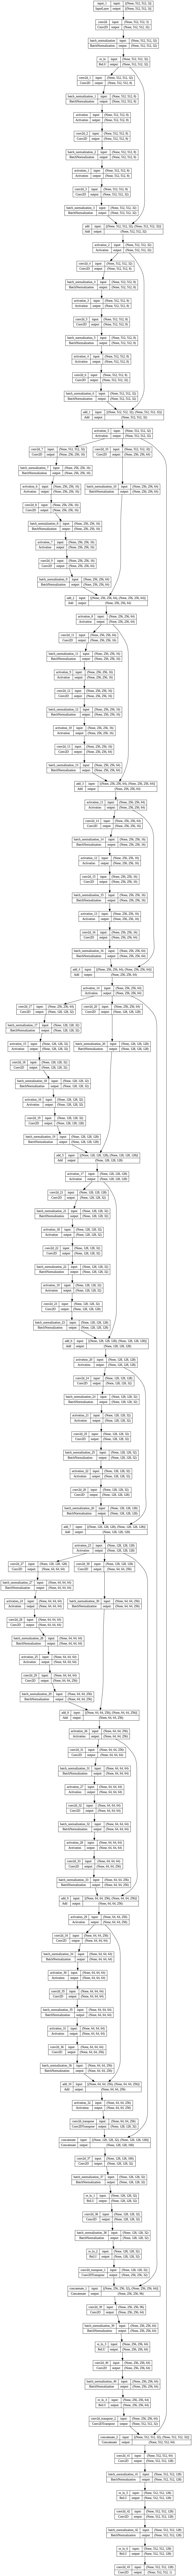

In [50]:
utils.plot_model(model, show_shapes=True)

#### Training

In [79]:
# Customize Dice coefficient
# K = tf.keras.backend

# range: 0 ~ 1
def dice_coef(y_true, y_pred):
    # y_true_f = K.flatten(y_true)
    # y_pred_f = K.flatten(y_pred)

    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    # intersection = K.sum(y_true_f * y_pred_f)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    y_true_f = tf.reduce_sum(y_true_f)
    y_pred_f = tf.reduce_sum(y_pred_f)
    return (2. * intersection) / (y_true_f + y_pred_f + 1e-7) # 1e-6, 1e-7

# Customized loss function
# range: 1 ~ 0
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# IoULoss

In [98]:
model.compile(optimizer=optimizers.AdamW(), 
              #loss='binary_crossentropy', 
              loss=dice_loss,
              metrics=[dice_coef]
              
              )

In [99]:
weight_saver = callbacks.ModelCheckpoint('seg.h5', 
                                         save_best_only=True)
earlystop = callbacks.EarlyStopping(patience=50)

In [86]:
logs = model.fit(train_gen,
                 validation_data = val_gen,
                 epochs=100,
                 callbacks = [weight_saver, earlystop])

Epoch 1/100
4/4 [==============================] - 3s 899ms/step - loss: 0.0834 - dice_coef: 0.6843 - val_loss: 0.1003 - val_dice_coef: 0.6976
Epoch 2/100
4/4 [==============================] - 3s 712ms/step - loss: 0.0901 - dice_coef: 0.6813 - val_loss: 0.1014 - val_dice_coef: 0.6923
Epoch 3/100
4/4 [==============================] - 3s 727ms/step - loss: 0.0916 - dice_coef: 0.6737 - val_loss: 0.1047 - val_dice_coef: 0.6870
Epoch 4/100
4/4 [==============================] - 3s 851ms/step - loss: 0.0924 - dice_coef: 0.6757 - val_loss: 0.1046 - val_dice_coef: 0.6858
Epoch 5/100
4/4 [==============================] - 3s 725ms/step - loss: 0.0915 - dice_coef: 0.6760 - val_loss: 0.1048 - val_dice_coef: 0.6908
Epoch 6/100
4/4 [==============================] - 3s 723ms/step - loss: 0.0885 - dice_coef: 0.6834 - val_loss: 0.1066 - val_dice_coef: 0.6991
Epoch 7/100
4/4 [==============================] - 3s 718ms/step - loss: 0.0881 - dice_coef: 0.6812 - val_loss: 0.1226 - val_dice_coef: 0.6575

KeyboardInterrupt: ignored

In [100]:
logs = model.fit(train_gen,
                 validation_data = val_gen,
                 epochs=1000,
                 initial_epoch=310,
                 callbacks = [weight_saver, earlystop])

Epoch 311/1000
4/4 [==============================] - 37s 1s/step - loss: 0.2793 - dice_coef: 0.7207 - val_loss: 0.2301 - val_dice_coef: 0.7699
Epoch 312/1000
4/4 [==============================] - 4s 926ms/step - loss: 0.2430 - dice_coef: 0.7570 - val_loss: 0.2266 - val_dice_coef: 0.7734
Epoch 313/1000
4/4 [==============================] - 3s 714ms/step - loss: 0.2408 - dice_coef: 0.7592 - val_loss: 0.2498 - val_dice_coef: 0.7502
Epoch 314/1000
4/4 [==============================] - 3s 723ms/step - loss: 0.2359 - dice_coef: 0.7641 - val_loss: 0.2553 - val_dice_coef: 0.7447
Epoch 315/1000
4/4 [==============================] - 3s 905ms/step - loss: 0.2327 - dice_coef: 0.7673 - val_loss: 0.2152 - val_dice_coef: 0.7848
Epoch 316/1000
4/4 [==============================] - 3s 747ms/step - loss: 0.2299 - dice_coef: 0.7701 - val_loss: 0.2165 - val_dice_coef: 0.7835
Epoch 317/1000
4/4 [==============================] - 3s 726ms/step - loss: 0.2275 - dice_coef: 0.7725 - val_loss: 0.2789 - va

#### Evaluate

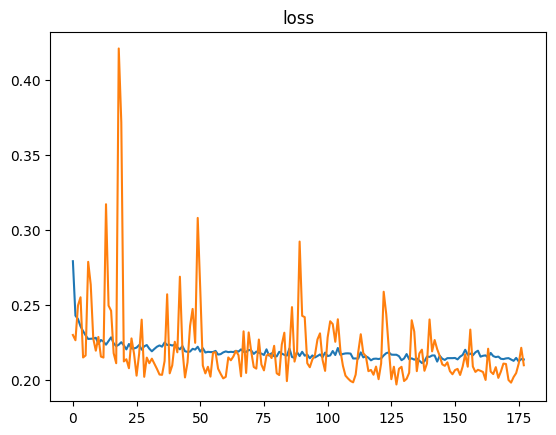

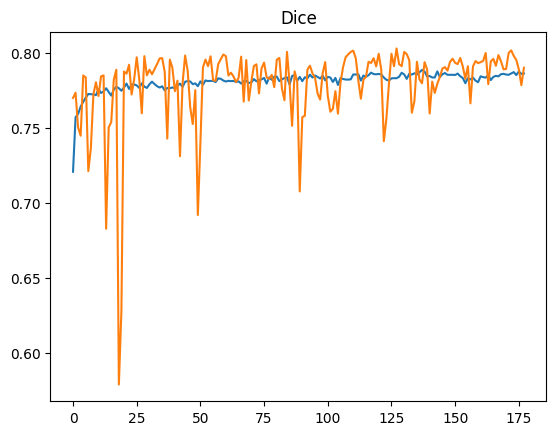

In [101]:
history = logs.history
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('loss')
plt.show()
plt.plot(history['dice_coef'])
plt.plot(history['val_dice_coef'])
plt.title('Dice')
plt.show()

In [102]:
model_final = models.load_model('seg.h5', compile=False)

0
1/1 [==============================] - 1s 1s/step


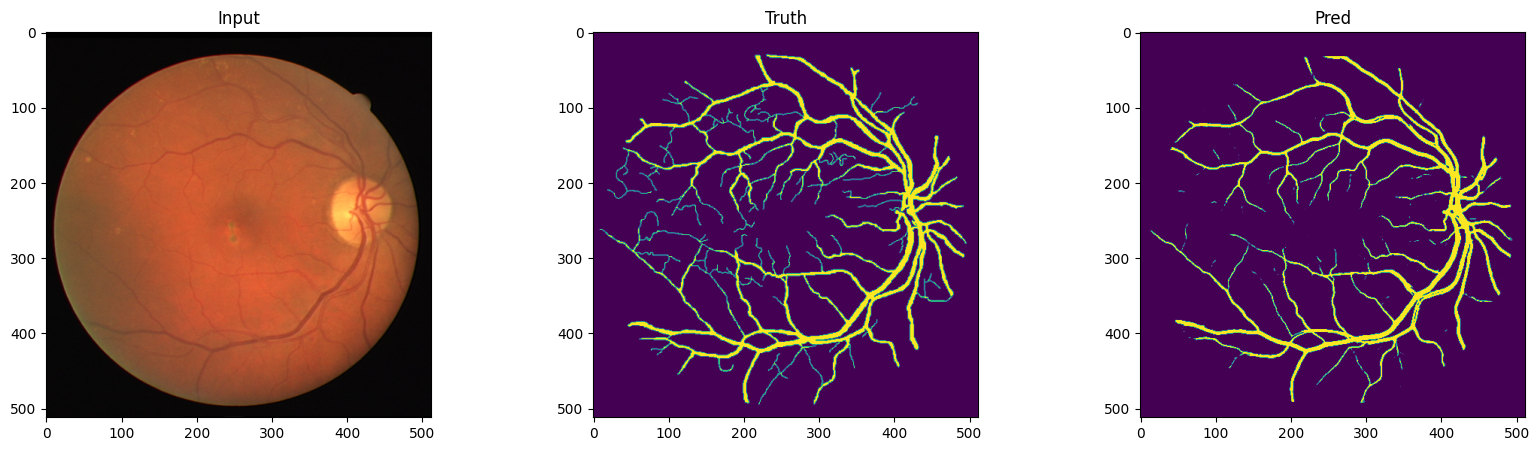

In [103]:
# Sample 1 batch
batch_idx = np.random.randint(len(val_gen))
print(batch_idx)
data = val_gen[batch_idx]
imgs, mask = data # (bs, 512, 512, 3), (bs, 512, 512, 1)
mask_pred = model_final.predict(imgs)

# show inputs
img_idx = np.random.randint(len(imgs)) # sample 1 image from batch
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.imshow(imgs[img_idx])
plt.title('Input')

# show ground truth & model prediction
plt.subplot(1, 3, 2)
plt.imshow(mask[img_idx, :, :, 0])
plt.title('Truth')
plt.subplot(1, 3, 3)
plt.imshow(mask_pred[img_idx, :, :, 0])
plt.title('Pred')
plt.show()
# plt.imshow(mask_pred[img_idx, :, :, 0], cmap='gray')

In [104]:
# Displayed with different threshold
mask_pred_raw = mask_pred[img_idx, :, :, 0]
mask_pred_raw

array([[5.1324805e-06, 2.1446993e-05, 3.1074760e-05, ..., 1.7038945e-05,
        9.6632466e-05, 1.6551050e-04],
       [1.7860393e-05, 2.7281265e-05, 2.2440574e-05, ..., 1.3609614e-05,
        2.3121145e-05, 1.0747380e-04],
       [1.5389085e-05, 1.3065934e-05, 1.1688878e-05, ..., 4.7458193e-06,
        7.1256341e-06, 3.2049746e-05],
       ...,
       [9.7370166e-06, 1.6336508e-05, 1.4171726e-05, ..., 6.2668628e-06,
        8.1432490e-06, 2.6770454e-05],
       [4.8515882e-05, 2.4379857e-05, 1.7886114e-05, ..., 9.0195426e-06,
        2.6540152e-05, 4.9962055e-05],
       [4.7149269e-06, 7.2425546e-06, 1.0192455e-05, ..., 6.9774646e-06,
        8.9014129e-06, 2.7131589e-06]], dtype=float32)

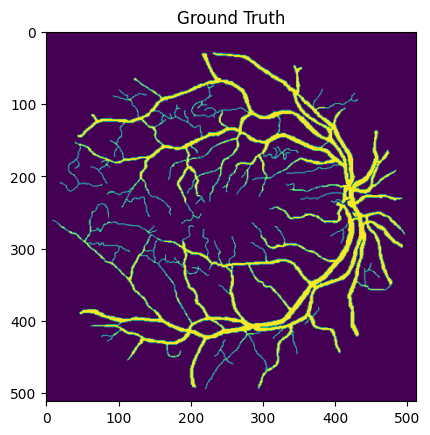

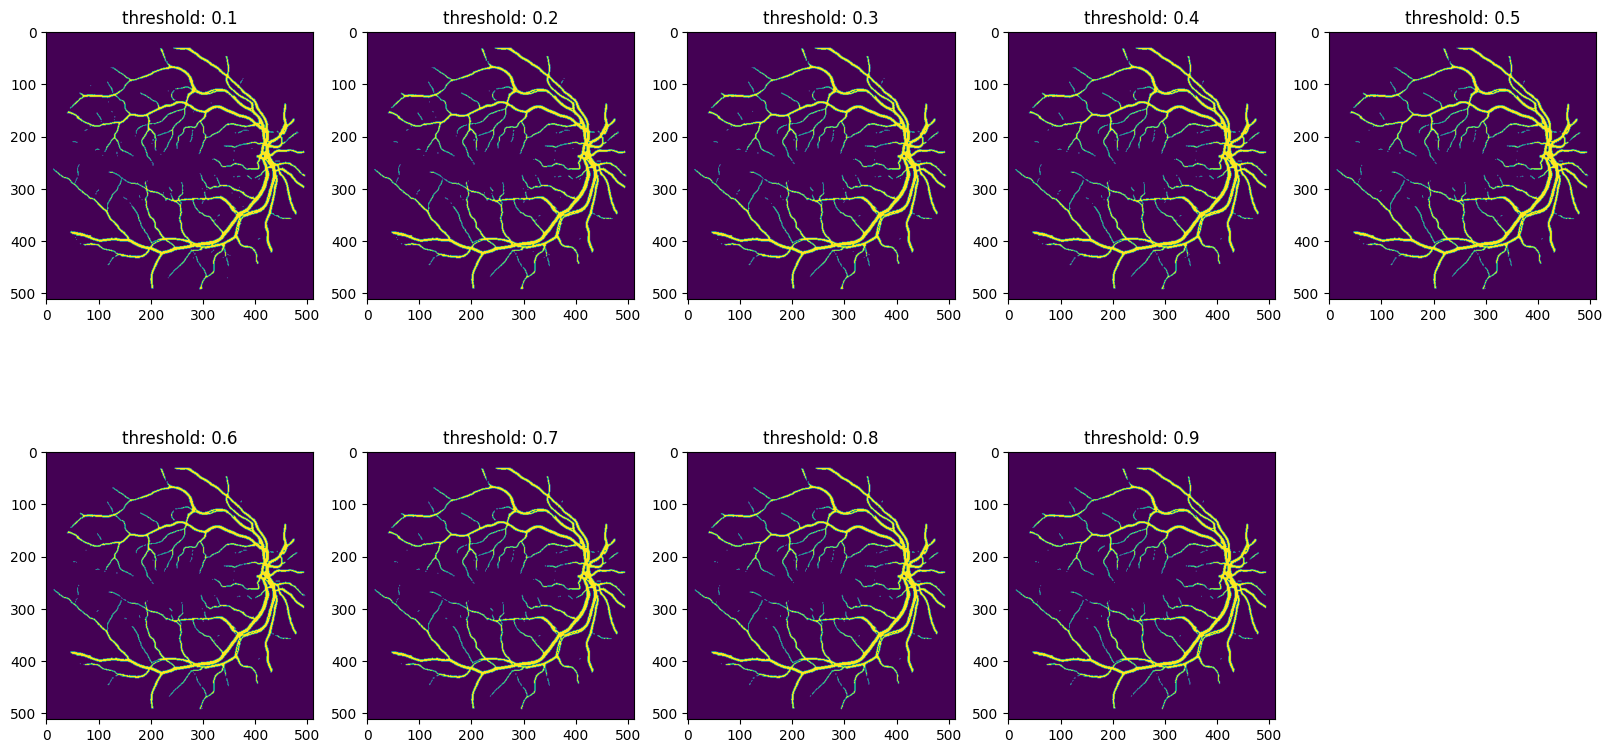

In [105]:
# threshold 0.1 ~ 0.9
plt.imshow(mask[img_idx, :, :, 0])
plt.title('Ground Truth')
plt.show()

plt.figure(figsize=(20, 10))
for i in range(1, 10):
    plt.subplot(2, 5, i)
    threshold = i * 0.1
    mask_threshold = mask_pred_raw.copy()
    mask_threshold[mask_threshold <= threshold] = 0.
    mask_threshold[mask_threshold > threshold] = 1.
    plt.imshow(mask_threshold)
    plt.title(f'threshold: {threshold:.1f}')
plt.show()

#### Make Kaggle prediction

https://www.kaggle.com/c/sai-vessel-segmentation2

In [106]:
# make prediction
threshold = 0.3 # 0.5
outputs = []
for i in range(len(test_gen)):
    x_test = test_gen[i]
    y_preds = model_final.predict(x_test)
    y_preds[y_preds <= threshold] = 0
    y_preds[y_preds > threshold] = 1
    for y_pred in y_preds:
        dots = np.where(y_pred.flatten() == 1)[0]
        run_lengths = []
        prev = -2
        for b in dots:
            if (b > prev +1):
                run_lengths.extend((b+1,0))
            run_lengths[-1] += 1
            prev = b
        output = ' '.join([str(r) for r in run_lengths])
        outputs.append(output)

1/1 [==============================] - 0s 31ms/step


In [97]:
df = pd.DataFrame(columns=['Id', 'Predicted'])
df['Id'] = [str(i) for i in range(20)]
df['Predicted'] = outputs
df.to_csv('submission.csv', index=None)
df

,Id,Predicted
0,0,15108 6 15590 7 15620 6 15651 3 16102 7 16133 ...
1,1,15104 3 15615 8 16127 9 16142 6 16640 9 16654 ...
2,2,12555 9 13065 10 13577 10 14088 9 14543 2 1459...
3,3,13046 5 13558 6 14070 7 14583 7 15096 6 15608 ...
4,4,16131 2 16640 6 16676 2 17150 8 17186 5 17661 ...
5,5,16126 4 16638 3 17150 4 17190 2 17663 3 17701 ...
6,6,15630 4 16101 8 16141 6 16609 12 16653 6 17121...
7,7,15078 5 15122 2 15590 7 15632 5 16103 7 16143 ...
8,8,14577 1 15088 6 15123 6 15600 7 15609 3 15634 ...
9,9,15615 2 16126 5 16600 5 16638 6 17111 7 17151 ...
